### **What is Image Denoising?**
![](https://miro.medium.com/max/500/0*LkdV1TzFpI0AYeQb.png)

- Image denoising is the technique of removing noise or distortions from an image. There are a vast range of application such as blurred images can be made clear.
- However, since noise, edge, and texture are high frequency components, it is difficult to distinguish them in the process of denoising and the denoised images could inevitably lose some details.
- An image is often corrupted by noise in its acquisition and transmission. Image denoising is used to remove the additive noise while retaining as much as possible the important signal features. Generally, data sets collected by image sensors are contaminated by noise.

One of the applications of deep learning autoencoders is image reconstruction. But it is not necessary that the input images will always be clean. Sometimes, the input images for autoencoders can be noisy. In that case, the deep learning autoencoder has to denoise the input images, get the hidden code representation, and then reconstruct the original images. It is one of the useful applications of autoencoders in deep learning.


### **Denoising AutoEncoder**

- Denoising autoencoders are an extension of the basic autoencoders architecture. 
- An autoencoder neural network tries to reconstruct images from hidden code space. 
- In denoising autoencoders, we will introduce some noise to the images. The denoising autoencoder network will also try to reconstruct the images. But before that, it will have to cancel out the noise from the input image data. In doing so, the autoencoder network will learn to capture all the important features of the data.

#### **Loss Function**
- Training a denoising autoencoder result in a more robust neural network model that can handle noisy data quite well.

$$ L_(x,r) = L(x,(g(f(x))) $$

- where $L$ is loss function, $x$ is the input, and r = $g(f(x))$ is the reconstruction by decoder. In this case Error Function is Squared Error.

#### **Now Denoising**

- Denoising Autoencoders, we tend to add some noise to the input $x$ to make it $\bar{x}$.

$$ L_(x,r) = L(x, g(f(\bar{x}))) $$

- In the autoencoder network, the loss function always introduces a penalty when the input x is dissimilar from the reconstruction r.
- If the loss function is the squared error loss, then we can make it a bit more specific with the following equation.

$$ l = \frac{1}{2} \sum_{i=1}^N (x_{i} – \hat{\tilde{x_{i}}})^2 $$

- where $N$ is the total number of training examples.

### **Fashion MNIST adding Noise to Images**
- We will need noisy images for the inputs, and for that, we will be adding noise manually to the images.
![](https://debuggercafe.com/wp-content/uploads/2020/01/Autoencoder-Network-Copy.jpg)
- So, all in all, we will give noisy images as inputs to the autoencoder neural network, then the encoder neural network will try to get the compress latent space representation. And the decoder part of the network will reconstruct the images. We will finally get to see how well our model performs after training when we give test images for denoising and reconstruction to it.

### **1.Load Libraries**

The imported modules include:

* `torchvision`: contains many popular computer vision datasets, deep neural network architectures, and image processing modules. We will use this to download the CIFAR10 dataset.
* `torch.nn`: contains the deep learning neural network layers such as `Linear()`, and `Conv2d()`.
* `transforms`: will help in defining the image transforms and normalizations.
* `optim`: contains the deep learning optimizer classes such as `MSELoss()` and many others as well.
* `functional`: we will use this for activation functions such as ReLU.
* `DataLoader`: eases the task of making iterable training and testing sets.

In [2]:
# torch loaded...!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision loaded...!!!
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchsummary import summary

# matplotlib loaded...!!!
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tqdm import tqdm

### **2.Define Constants**

In [2]:
# Constants
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.5 # constant NOISE_FACTOR which defines the amount of noise that we will add to our images. 

### **3.Prepare the Data**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

### **4.Data Loader and Download**

In [4]:
# Download the FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data_new', train = True, download= True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data_new', train = False, download= True, transform=transform)

# Load the dataset in the dataloader
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)



C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
for batch in trainLoader:
    batch1 = batch
    break

batch1[0].shape, batch[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### **5.Some Helper Function**

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
        
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, 'Saved_Images/' + name + '.png')

### **6.Define the AutoEncoder Neural Network**

In [7]:
class AutorEncoder(nn.Module):
    def __init__(self):
        super(AutorEncoder, self).__init__()
        
        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        
    def forward(self, x):
        # Encoder
        x = self.pool(F.relu(self.enc1(x)))
        x = self.pool(F.relu(self.enc2(x)))
        x = self.pool(F.relu(self.enc3(x)))
        x = self.pool(F.relu(self.enc4(x))) # latent space representation
        
        # Decoder
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = torch.sigmoid(self.out(x))
        
        return x

model = AutorEncoder().to(device)

In [8]:
print(model)

AutorEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 28, 28]          640
├─MaxPool2d: 1-2                         [-1, 64, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 14, 14]          18,464
├─MaxPool2d: 1-4                         [-1, 32, 7, 7]            --
├─Conv2d: 1-5                            [-1, 16, 7, 7]            4,624
├─MaxPool2d: 1-6                         [-1, 16, 3, 3]            --
├─Conv2d: 1-7                            [-1, 8, 3, 3]             1,160
├─MaxPool2d: 1-8                         [-1, 8, 1, 1]             --
├─ConvTranspose2d: 1-9                   [-1, 8, 3, 3]             584
├─ConvTranspose2d: 1-10                  [-1, 16, 7, 7]            1,168
├─ConvTranspose2d: 1-11                  [-1, 32, 14, 14]          2,080
├─ConvTranspose2d: 1-12                  [-1, 64, 28, 28]          8,256
├─Conv2d: 1-13                           [-1, 1, 28, 28]        

C:\Users\SHIVA\miniconda3\envs\pytorch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 28, 28]          640
├─MaxPool2d: 1-2                         [-1, 64, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 14, 14]          18,464
├─MaxPool2d: 1-4                         [-1, 32, 7, 7]            --
├─Conv2d: 1-5                            [-1, 16, 7, 7]            4,624
├─MaxPool2d: 1-6                         [-1, 16, 3, 3]            --
├─Conv2d: 1-7                            [-1, 8, 3, 3]             1,160
├─MaxPool2d: 1-8                         [-1, 8, 1, 1]             --
├─ConvTranspose2d: 1-9                   [-1, 8, 3, 3]             584
├─ConvTranspose2d: 1-10                  [-1, 16, 7, 7]            1,168
├─ConvTranspose2d: 1-11                  [-1, 32, 14, 14]          2,080
├─ConvTranspose2d: 1-12                  [-1, 64, 28, 28]          8,256
├─Conv2d: 1-13                           [-1, 1, 28, 28]        

### **7. Optimizer and Loss Function**

In [10]:
# the loss function
loss_fn = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### **8.Defining the training and test function**

In [11]:
def train(net, trainLoader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                img, _ = data # we do not need the image labels
                # add noise to the image data
                img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0., 1.)
                img_noisy = img_noisy.to(device)
                optimizer.zero_grad()
                outputs = net(img_noisy)
                loss = loss_fn(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss)    
            
            loss = running_loss / len(trainLoader)
            train_loss.append(loss)
            # print(f"Epoch {epoch} loss: {loss}")            
            save_decoded_image(img_noisy.cpu().data, name='noisy{}'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='denoised{}'.format(epoch))           
    
    return train_loss                            
                
        
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)
        outputs = net(img_noisy)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(img_noisy, 'noisy_test_input.png')
        save_image(outputs, 'denoised_test_reconstruction.png')
        break

### **9.Model Training and Result Analysis**

Epoch 10: 100%|██████████| 1875/1875 [00:52<00:00, 35.56batch/s, loss=tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward>)]


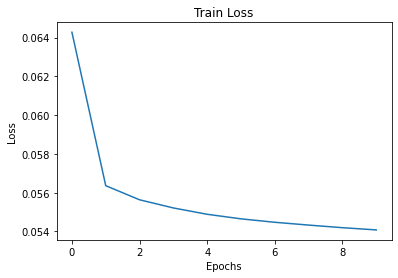

In [12]:
make_dir()
train_loss = train(model, trainLoader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./Saved_Images/conv_ae_fahsionmnist_loss.png')
test_image_reconstruction(model, testLoader)

### 

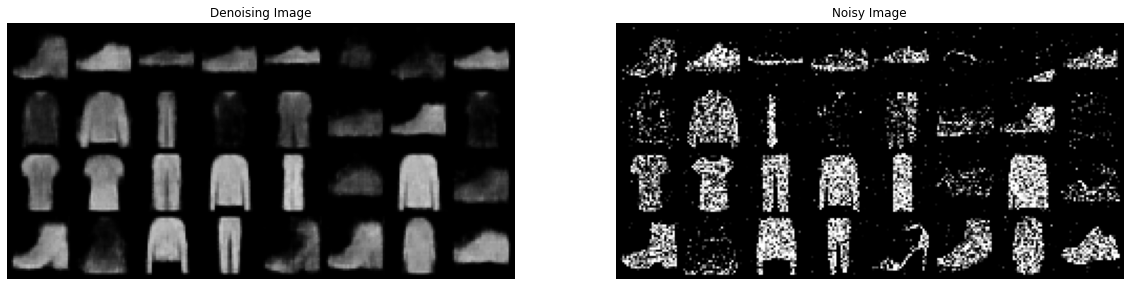

In [12]:
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
img = mpimg.imread("D:\\ashishpatel26_github\\Pytorch Learning\\Saved_Images\\denoised9.png")
img1 = mpimg.imread("D:\\ashishpatel26_github\\Pytorch Learning\\Saved_Images\\noisy9.png")
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Denoising Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img1)
plt.title('Noisy Image')
plt.axis('off')
plt.show()